<a href="https://colab.research.google.com/gist/Oriinta/1eed156ca579bc0a43108b626d66821a/digits-recognition_own.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Проект - распознавание рукописных цифр на основе сети LeNet**
##(прописать все слои вручную + модицифировать для улучшения результата)

In [0]:
#Подгружаем библиотеки и фиксируем рандом для получения одинаковых результатов
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
#Подгружаем датасет рукописных чисел
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
len(y_train), len(y_test)

(60000, 10000)

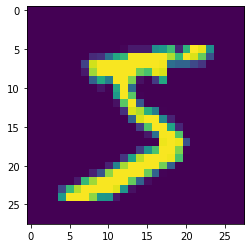

tensor(5)


In [5]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
#добавляем размерность каналов
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [7]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [0]:
#создаем нейросеть, в отличие от LeNet заменяем функцию активации тангенс на ReLU, чтобы избежать затухания градиента
#avg пулинг заменяем на max
#свертки 5*5 заменяем на две последовательные 3*3 для сокращения вычислений и снижения риска увеличения loss
#добавляем батч нормализацию для более быстрого обучения

class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='ReLU',
                 pooling='max',
                 conv_size=3,
                 use_batch_norm=True):
        super(LeNet5, self).__init__()
        
                
        self.conv1_1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.conv1_2 = torch.nn.Conv2d(
            in_channels=6, out_channels=6, kernel_size=3, padding=1)
    
        self.act1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        
   
        self.conv2_1 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=3, padding=0)
        self.conv2_2 = torch.nn.Conv2d(
            in_channels=16, out_channels=16, kernel_size=3, padding=0)
        
        self.act2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = torch.nn.ReLU()
    
        self.fc2 = torch.nn.Linear(120, 150)
        self.act4 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(150, 10)
    
    def forward(self, x):
        
        x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        
       
        x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
lenet5 = LeNet5()

In [12]:
#переводим на видеокарту
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

#в качестве функции потерь - бинарная кросс-энтропия
#град спуск осуществляется с помощью оптимизатора Адама со стандартными параметрами
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

#аугментация. увеличиваем датасет с помощью картинок с шумом
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x[np.random.permutation(3), :, :]),
    transforms.RandomErasing()])


batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

#цикл градиентного спуска (расчет, шаг и обнуление после каждого шага)

for epoch in range(9):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        lenet5.train()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = lenet5.forward(X_batch) 

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

#расчет предсказаний, подсчет accuracy, loss

    lenet5.eval()
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(accuracy)
   

tensor(0.9909)
tensor(0.9916)
tensor(0.9920)
tensor(0.9892)
tensor(0.9911)
tensor(0.9920)
tensor(0.9902)
tensor(0.9925)
tensor(0.9901)


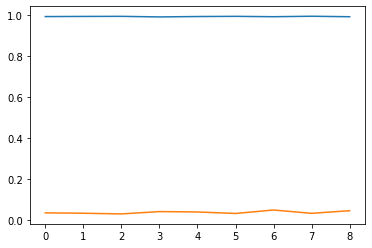

In [13]:
#графики динамики accuracy и loss в течение эпох
plt.plot(test_accuracy_history)
plt.plot(test_loss_history)

